In [2]:
import sys
sys.path.append('..')

from enum import Enum

from sqlalchemy import func, or_
import pandas as pd
import numpy as np

from src.models.enums.facebook.adset import Target
from src.database.session import SessionLocal
from src.models import *
from src.utils.common import print_dict
from src.utils.pd import eval_but_leave_string_if_you_cant

db = SessionLocal()

In [3]:
data = (
    db.query(
        FacebookAdset.targeting,
        FacebookAdset.targeting.op("->>")("custom_audiences").label("custom_audiences"),
        FacebookAdset.targeting.op("->>")("excluded_custom_audiences").label("excluded_custom_audiences"),
        FacebookAdset.targeting.op("->>")("flexible_spec").label("flexible_spec"),
        FacebookAdset.target,
    )
    .filter(
        func.random() < 0.01,
        or_(
            FacebookAdset.targeting.op("->>")("custom_audiences") != None,
            FacebookAdset.targeting.op("->>")("flexible_spec") != None,
        ),
    )
    .limit(1000)
    .all()
)

In [4]:
i = np.random.randint(0, len(data)-1)
row = data[i]
print(row.target)
# print(row.targeting)
if row.custom_audiences is not None:
    print('custom:')
    print_dict([d['name'] for d in eval(row.custom_audiences)])
if row.excluded_custom_audiences is not None:
    print('excluded:')
    print_dict([d['name'] for d in eval(row.excluded_custom_audiences)])
if row.flexible_spec is not None:
    print('interests:')
    print_dict([d.get('interests', [{}])[0].get('name', None) for d in eval(row.flexible_spec) if type(d) == dict])

Target.acquisition
custom:
[
    "Lookalike (AU, 5%) - Loyal_Customers_AU",
    "Lookalike (NZ, 5%) - Purchase_All_Time_Global"
]
excluded:
[
    "All_Profiles_Live_AU",
    "All_Profiles_Live_NZ",
    "RT_BNP_60_Days_US",
    "Purchased_10_Days_AU_NZ",
    "All NZ website visitors - L30d",
    "Facebook Post Engaged - L60days NZ/AU",
    "Insta Post Engaged - L60days NZ/AU"
]


In [7]:
df = pd.DataFrame(data)
df = df.applymap(eval_but_leave_string_if_you_cant)
df.target = df.target.apply(lambda x: x.value if type(x) == Target else x)
check_for_lookalike = (
    lambda x: any(["lookalike" in d["name"].lower() for d in x]) if type(x) == list else False
)
df["lookalike"] = df.custom_audiences.apply(check_for_lookalike)
df.groupby(
    [df.custom_audiences.notna(), df.excluded_custom_audiences.notna(), df.flexible_spec.notna(), df.lookalike]
).apply(len)

custom_audiences  excluded_custom_audiences  flexible_spec  lookalike
False             False                      True           False        393
                  True                       True           False        175
True              False                      False          False         77
                                                            True          84
                                             True           False          6
                                                            True          14
                  True                       False          False        103
                                                            True         123
                                             True           False          9
                                                            True          16
dtype: int64

In [10]:
for i, row in df.iterrows():
    if row.custom_audiences is not None:
        print('custom:')
        print_dict([d['name'] for d in row.custom_audiences])
    if row.excluded_custom_audiences is not None:
        print('excluded:')
        print_dict([d['name'] for d in row.excluded_custom_audiences])
    if row.flexible_spec is not None:
        print('interests:')
        print_dict([d.get('interests', [{}])[0].get('name', None) for d in row.flexible_spec if type(d) == dict])

interests:
[
    "Weight loss (Fitness And wellness)",
    "Baking",
    "Recipes",
    null
]
interests:
[
    "Tottenham Hotspur F.C."
]
interests:
[
    "The Elder Scrolls V: Skyrim"
]
interests:
[
    "Sports science",
    null
]
interests:
[
    "Lululemon Athletica"
]
interests:
[
    "Fashion and Style"
]
custom:
[
    "Lookalike (US, 10%) - 15.9% Page View (4 times)"
]
interests:
[
    "John Deere"
]
interests:
[
    null
]
interests:
[
    null
]
interests:
[
    "Outdoor enthusiast"
]
custom:
[
    "Lookalike (AU, 1%) - Generator Contacts 4:09:17"
]
excluded:
[
    "Generator Contacts 4:09:17"
]
custom:
[
    "GEN PLACE BUYING GUIDE LEADS",
    "Lookalike (AU, 5%) - GEN PLACE BUYING GUIDE LEADS"
]
interests:
[
    "Can-Am Off-Road",
    null
]
interests:
[
    "Toys",
    null
]
interests:
[
    "Bird feeder",
    null
]
custom:
[
    "Lookalike (AU, CA and 2 others, 1% to 2%) - VM - 180D - TOS 25%"
]
excluded:
[
    "Website Visitors 180 Days"
]
interests:
[
    "Trucks",
  

In [43]:
col = 'flexible_spec'
row = df[df[col].notna()].sample(1)
print_dict(row[col].item())

In [49]:
row = df[df[col].notna()].sample(1)
print_dict(row[col].item())

[
    {
        "interests": [
            {
                "id": "6003091387658",
                "name": "Tebess\u00fcm"
            },
            {
                "id": "6003180853133",
                "name": "Dental tourism"
            }
        ]
    }
]


In [92]:
class Audience(str, Enum):
    broad = "broad"
    lookalike = "lookalike"
    interest = "interest"


def deduce_audience(targeting) -> Audience:
    flexible_spec = targeting.get("flexible_spec", [])
    interest_dicts = [d.get("interests", []) for d in flexible_spec if type(d) == dict]
    interests_packed = [[d.get("name") for d in interest] for interest in interest_dicts]
    interests = [interest for interest in sum(interests_packed, []) if interest is not None]
    if len(interests):
        return {'interests': interests, 'audience': Audience.interest}

    custom_audiences = targeting.get("custom_audiences", [])
    custom_audiences_names = [d.get("name", "") for d in custom_audiences if type(d) == dict]
    if any(['lookalike' in ca_name.lower() for ca_name in custom_audiences_names]):
        return {'audience': Audience.lookalike}
    return {'audience': Audience.broad}

In [95]:
df['audience'] = df.targeting.apply(lambda x: deduce_audience(x)['audience'])
df['interests'] = df.targeting.apply(lambda x: deduce_audience(x).get('interests', []))

In [ ]:
from wordcloud import WordCloud

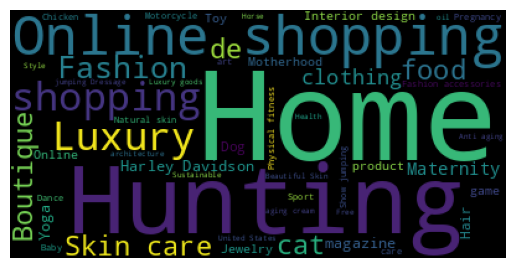

In [103]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt
wc = WordCloud()
wc.generate(', '.join(sum(df.interests.tolist(), [])))
plt.imshow(wc)
plt.axis('off')
plt.show()

In [96]:
df.audience.value_counts()

Audience.interest     560
Audience.broad        228
Audience.lookalike    212
Name: audience, dtype: int64

In [90]:
col = 'excluded_custom_audiences'

row = df[df.audience == Audience.lookalike].sample(1)
print_dict(row[col].item())

[
    {
        "id": "6207298051458",
        "name": "All Purchase 180d"
    }
]
